In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [0]:
## Feature Extraction ##
df_titanic = pd.read_csv('titanic.csv')

#dropping unnecessary columns
df_titanic.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'Embarked'], axis=1, inplace=True)

#transforming Sex column values: male-2, female-1
df_titanic['Sex'].replace(['female','male'], [1,2], inplace=True)

df_titanic['Survived'].replace([0,1], [-1,1], inplace=True)

#checking for NaN values
print(df_titanic.apply(axis=0, func=lambda x : any(pd.isnull(x))))
print('\n')

#total NaN values in Age column
print(sum(df_titanic['Age'].isnull()))

#Replacing NaNs with mean of column
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].mean())

print(sum(df_titanic['Age'].isnull()))
df_titanic.head()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
dtype: bool


177
0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,-1,3,2,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,-1,3,2,35.0,0,0,8.0500


In [0]:
X = df_titanic.drop(['Survived'], axis=1)
y = df_titanic['Survived']

#normalizing data
scaler = StandardScaler()
scaler.fit(X)
processed_data = scaler.transform(X)

X = pd.DataFrame(processed_data, columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'])

X.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337


In [0]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [0]:
#helper to calculate final error rate
def calculate_error_rate(predictions, ground_truth):
  return sum(predictions != ground_truth) / float(len(ground_truth))

In [0]:
#Using DecisionTreeClassifier as base classifier
clf_dt = DecisionTreeClassifier(max_depth=1)
clf_dt.fit(X_train, y_train)

train_predictions = clf_dt.predict(X_train)
test_predictions = clf_dt.predict(X_test)

#list of errors for each iteration
err_train = []
err_test = []

err_train.append(calculate_error_rate(train_predictions, y_train))
err_test.append(calculate_error_rate(test_predictions, y_test))

# print(err_train,err_test)

In [0]:
### Adaboost classifier ###
def Adaboost_clf(X_train, y_train, X_test, y_test, base_clf, M):
  
  err_train = []
  err_test = []
  
  train_len = len(X_train)
  test_len = len(X_test)
  
  #initializing weights
  u = np.ones(train_len) / train_len

  #initializing prediction arrays
  predictions_train, predictions_test = [np.zeros(train_len), np.zeros(test_len)]
  
  for i in range(M):
    
    base_clf.fit(X_train, y_train, sample_weight = u)
    
    i_predictions_train = base_clf.predict(X_train)
    i_predictions_test = base_clf.predict(X_test)
    
    epsilon_i = np.dot(u,  (i_predictions_train != y_train)) / sum(u)
    
    #alpha - voting parameter
    alpha_i = 0.5 * np.log((1 - epsilon_i) / float(epsilon_i))
    
    #updating weights
    u = np.array(np.multiply(u, np.exp(-alpha_i * i_predictions_train * y_train)))
    
    predictions_train = [sum(x) for x in zip(predictions_train, 
                                          [x * alpha_i for x in i_predictions_train])]
    predictions_test = [sum(x) for x in zip(predictions_test, 
                                          [x * alpha_i for x in i_predictions_test])]
    
  predictions_train, predictions_test = np.sign(predictions_train), np.sign(predictions_test)

  return accuracy_score(y_test, predictions_test), calculate_error_rate(predictions_train, y_train), calculate_error_rate(predictions_test, y_test)
  

In [0]:
x_range = range(100, 600, 100)
accuracy = []
for i in x_range:    
  err_ = Adaboost_clf(X_train, y_train, X_test, y_test, clf_dt, i)
  err_train.append(err_[1])
  err_test.append(err_[2])
  accuracy.append(err_[0])

In [0]:
print('Best test error:',max(err_test))
print('Best train error:',max(err_train))
print('Best accuracy on test set:',max(accuracy))

Best test error: 0.19322033898305085
Best train error: 0.2231543624161074
Best accuracy on test set: 0.8169491525423729


In [0]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['blue', 'green'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,600,80))
    plot1.set_ylabel('Error rate')
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

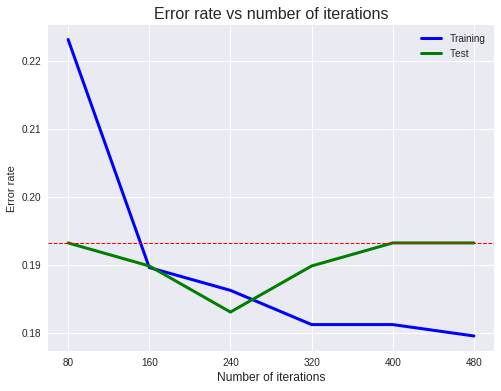

In [0]:
plot_error_rate(err_train, err_test)

## Observations:

- We can notice that Adaboost is decreasing error rate on train set rapidly and then it stops decreasing much.
- Also, from the point where train error stops decreasing, the test error starts increasing, which implies we found local minima for test error.
- Hence, after this local minima adabost seems to overfit on training set, which in turn increase test error rate from there on.